<a href="https://colab.research.google.com/github/Sundragon1993/TUM_cv3dst/blob/main/TUM_cv3dst_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) (IN2375) Exercise

In this exercise we provide you with a baseline multi-object tracker on the [MOT16](https://motchallenge.net/data/MOT16/) dataset. Your task is to improve its tracking performance by applying different techniques from the lecture. As most modern multi-object trackers, the provided baseline follows the tracking-by-detection paradigm. To this end, an object detector is applied to each frame indepdently and in a subsequent data association step the detections are combined to tracks over multiple frames. The challenge is to connect the correct detections of the same object and produce identity preserving tracks.

The improvement on the provided baseline tracker can be achieved in multiple ways:

*   Improving the object detector.
*   Improving the tracker (data association step).
*   Incorporating segmentation information.



## Setup

### Download and extract project data to your Google Drive

1.   Install Google Drive on your desktop.
2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
3.   Download [this](https://vision.in.tum.de/webshare/u/meinhard/cv3dst_exercise.zip) zip file to your desktop and extract it into the `Colab Notebooks` folder in your Google Drive.
4.   Wait until Google Drive finished the synchronisation. (This might take a while.)


#### Connect the notebook to your Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !wget "https://vision.in.tum.de/webshare/u/meinhard/cv3dst_exercise.zip"

In [ ]:
# !unzip "/content/cv3dst_exercise.zip" -d "gdrive/My Drive/Colab Notebooks/"

In [2]:
root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"

The `root_dir` path points to the directory and the content in your Google Drive.

In [3]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/src/tracker"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/src/deep_sort"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/src/tools"

data  models  output  src
data_obj_detect.py  __init__.py		__pycache__  utils.py
data_track.py	    object_detector.py	tracker.py
deep_sort_app.py	  iou_matching.py	preprocessing.py  utils.py
detection.py		  kalman_filter.py	__pycache__
evaluate_motchallenge.py  linear_assignment.py	tracker.py
__init__.py		  nn_matching.py	track.py
freeze_model.py  generate_detections.py  __pycache__


#### Install and import Python libraries

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(root_dir, 'src'))

!pip install tqdm lap
!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip

  Using cached https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip
  Created wheel for motmetrics: filename=motmetrics-1.1.3-cp36-none-any.whl size=134192 sha256=7d994481a886a6e016e72dd1d51ce13470691d80cd4d305eec7f6b4b114d3537
  Stored in directory: /tmp/pip-ephem-wheel-cache-h_lsh5fc/wheels/c9/e9/0a/79599df270874df0ab21a57a729e8a956aed3c744da3397efc
Successfully built motmetrics


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)

import motmetrics as mm
mm.lap.default_solver = 'lap'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [6]:
from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet

# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.

At this point the test set directort is still empty. Later in the semester we will provide you with the necesssary test sequences to submit to our challenge.

In [7]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/test"

MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13


In order to compare the tracking performance of different trackers without the effect of the object detector, the MOTChallenge provides a precomputed set of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, we want to allow you to improve on the object detections as well. Therefore, we participate in the MOT16 challenge with private detections.

## Instance segmentations

We provide the instance segmentations for the sequences `02`, `05`, `09` and `11`. These can be used for example to train a method which improves the bounding box position in occluded situations. See the original MOTS [webpage](https://www.vision.rwth-aachen.de/page/mots) for more info.

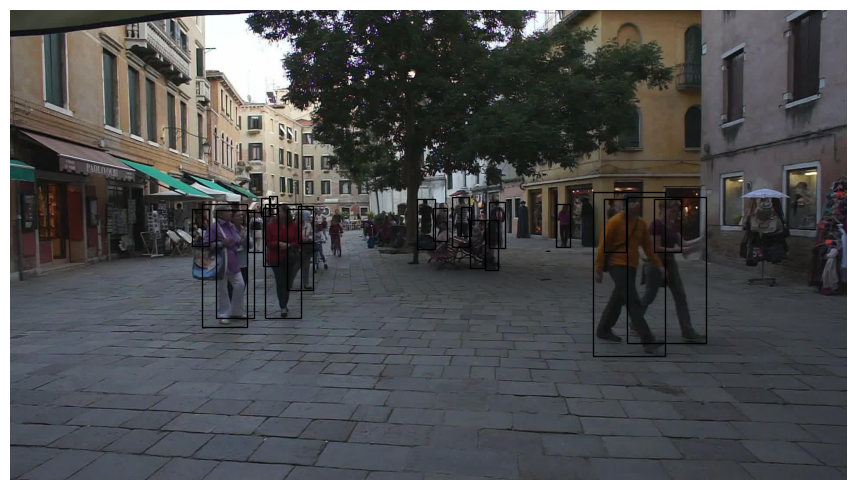

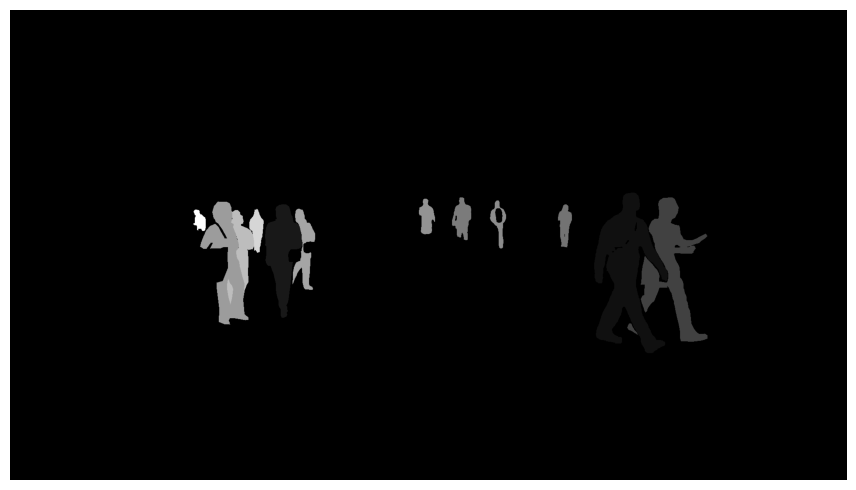

In [ ]:
seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)
# print(len(sequences))
for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame['img']
        
        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape
          
        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]),
                  box[2] - box[0],
                  box[3] - box[1],
                  fill=False,
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()

        if 'seg_img' in frame:
            seg_img = frame['seg_img']
            fig, ax = plt.subplots(1, dpi=dpi)
            fig.set_size_inches(width / dpi, height / dpi)
            ax.imshow(seg_img, cmap='gray')
            plt.axis('off')
            plt.show()
        break

In [ ]:
print('Length of sequences',len(sequences))
print('Type:',type(sequences))
for seq in sequences:
  print('Type of frames',type(seq))
  print('Length of frames',len(seq))
  for i, frame in enumerate(seq):
      print(frame.keys())
      print(frame['gt'].keys())
      # print(frame['gt'].values())
      print(frame['vis'].keys())
      # print(type(frame['seg_img']))
      break

Length of sequences 1
Type: <class 'tracker.data_track.MOT16Sequences'>
Type of frames tracker.data_track.MOT16Sequence
Length of frames 600
dict_keys(['img', 'img_path', 'gt', 'vis', 'seg_img'])
dict_keys([2, 3, 8, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 31, 36, 39, 68, 69, 70, 72])
dict_keys([2, 3, 8, 9, 10, 14, 15, 17, 18, 19, 20, 21, 22, 23, 26, 31, 36, 39, 68, 69, 70, 72])


# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [8]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/models"

faster_rcnn_fpn.model



## Configuration

In [9]:
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
obj_detect_nms_thresh = 0.3

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device)

FRCNN_FPN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample):

If you uncomment und run the following evaluation of the object detection training set, you should obtain the following evaluation result:

`AP: 0.8677356206210984 Prec: 0.9220907182151947 Rec: 0.9167998134001982 TP: 78611.0 FP: 6642.0`

In [ ]:
# import torchvision
# obj_detect = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# obj_detect.eval()

In [11]:
dataset_test = MOT16ObjDetect(os.path.join(root_dir, 'data/MOT16/train'),
                              obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# evaluate_obj_detect(obj_detect, data_loader_test)

# Multi-object tracking

We provide you with a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union.

Try to understand the baseline tracker and think of ideas on how to improve it with the knowledge from the lecture or even beyond.

## Configuration

In [31]:
seed = 12345
seq_name = 'MOT16-train'
data_dir = os.path.join(root_dir, 'data/MOT16')
output_dir = os.path.join(root_dir, 'output')

## Setup

In [32]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset
sequences = MOT16Sequences(seq_name, data_dir)
# print(len(sequences))

**Baseline tracker**

In [64]:
# tracker
class TrackerIoUAssignment(Tracker):
    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            # for t in self.tracks:
            #   print(t.print_result())

            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)
            
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)
            # print(self.tracks)
            # print(len(track_ids))
            # print(len(track_boxes))
            # print(len(boxes))
            # update existing tracks
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance):
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    match_id = np.nanargmin(dist)
                    t.box = boxes[match_id]
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids]

            # add new tracks
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
                    print('DEBUG for new boxes:',len(new_boxes))
                    print('DEBUG for new scores:',len(new_scores))
            self.add(new_boxes, new_scores)

        else:
          print(type(boxes))
          print(type(scores))
          self.add(boxes, scores)
        

tracker_base = TrackerIoUAssignment(obj_detect)

## My Tracker

In [ ]:
class HighSpeedTrackerIOU(Tracker):
    def __init__(self, detector, sigma_l, sigma_h, sigma_iou, t_min=0):
        super.__init__(detector)
        # sigma_l (float): low detection threshold.
        # sigma_h (float): high detection threshold.
        # sigma_iou (float): IOU threshold.
        # t_min (float): minimum track length in frames.
        self.sigma_l = sigma_l
        self.sigma_h = sigma_h
        self.sigma_iou = sigma_iou
        self.t_min = t_min
        self.inactivated_track = []
        self.tracks_active = []
        self.tracks_finished = []

    def track_iou(detections, sigma_l, sigma_h, sigma_iou, t_min):
        """
        Simple IOU based tracker.
        See "High-Speed Tracking-by-Detection Without Using Image Information by E. Bochinski, V. Eiselein, T. Sikora" for
        more information.
        Args:
             detections (list): list of detections per frame, usually generated by util.load_mot
             sigma_l (float): low detection threshold.
             sigma_h (float): high detection threshold.
             sigma_iou (float): IOU threshold.
             t_min (float): minimum track length in frames.
        Returns:
            list: list of tracks.
        """

        tracks_active = []
        tracks_finished = []

        for frame_num, detections_frame in enumerate(detections, start=1):
            # apply low threshold to detections
            dets = [det for det in detections_frame if det['score'] >= sigma_l]

            updated_tracks = []
            for track in tracks_active:
                if len(dets) > 0:
                    # get det with highest iou
                    best_match = max(dets, key=lambda x: iou(track['bboxes'][-1], x['bbox']))
                    if iou(track['bboxes'][-1], best_match['bbox']) >= sigma_iou:
                        track['bboxes'].append(best_match['bbox'])
                        track['max_score'] = max(track['max_score'], best_match['score'])

                        updated_tracks.append(track)

                        # remove from best matching detection from detections
                        del dets[dets.index(best_match)]

                # if track was not updated
                if len(updated_tracks) == 0 or track is not updated_tracks[-1]:
                    # finish track when the conditions are met
                    if track['max_score'] >= sigma_h and len(track['bboxes']) >= t_min:
                        tracks_finished.append(track)

            # create new tracks
            new_tracks = [{'bboxes': [det['bbox']], 'max_score': det['score'], 'start_frame': frame_num} for det in
                          dets]
            tracks_active = updated_tracks + new_tracks

        # finish all remaining active tracks
        tracks_finished += [track for track in tracks_active
                            if track['max_score'] >= sigma_h and len(track['bboxes']) >= t_min]

        return tracks_finished

    def data_association(self, boxes, scores):
        if self.tracks:
            dets = []
            for i, tr in enumerate(self.tracks):
                dets.append({'bbox': (tr.box[0], tr.box[1], tr.box[2], tr.box[3]), 'score': tr.score})

            boxes_in_track = [det for det in dets if det['score'] >= self.sigma_l]
            print(len(boxes_in_track))

            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)

            updated_tracks = []
            for track in self.tracks_active:
                if len(dets) > 0:
                    # get det with highest iou
                    best_match = max(boxes_in_track, key=lambda x: iou(track['bboxes'][-1], x['bbox']))
                    if iou(track['bboxes'][-1], best_match['bbox']) >= self.sigma_iou:
                        track['bboxes'].append(best_match['bbox'])
                        track['max_score'] = max(track['max_score'], best_match['score'])

                        updated_tracks.append(track)

                        # remove from best matching detection from detections
                        del boxes_in_track[boxes_in_track.index(best_match)]

                # if track was not updated
                if len(updated_tracks) == 0 or track is not updated_tracks[-1]:
                    # finish track when the conditions are met
                    if track['max_score'] >= self.sigma_h and len(track['bboxes']) >= self.t_min:
                        self.tracks_finished.append(track)

            # create new tracks
            new_tracks = [{'bboxes': [det['bbox']], 'max_score': det['score']} for det in boxes_in_track]
            tracks_active = updated_tracks + new_tracks

            # finish all remaining active tracks
            self.tracks_finished += [track for track in tracks_active
                                     if track['max_score'] >= sigma_h and len(track['bboxes']) >= self.t_min]
            self.tracks = self.tracks_finished

            # add new tracks
            # new_boxes = []
            # new_scores = []
            # for i, dist in enumerate(np.transpose(distance)):
            #     if np.isnan(dist).all():
            #         new_boxes.append(boxes[i])
            #         new_scores.append(scores[i])
            #         print('DEBUG for new boxes:', len(new_boxes))
            #         print('DEBUG for new scores:', len(new_scores))
            # self.add(new_boxes, new_scores)
        else:
            self.add(boxes, scores)


##DEEP SORT

In [29]:
# /content/gdrive/MyDrive/Colab Notebooks/cv3dst_exercise/src/model_data/mars-small128.pb
max_cosine_distance = 0.5
nn_budget = 100
nms_max_overlap = 0.8
tracker_data_dir = os.path.join(root_dir, 'src/model_data/mars-small128.pb')
print(tracker_data_dir)

# model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(tracker_data_dir, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric('cosine', max_cosine_distance, nn_budget)
tracker = Tracker(metric)

gdrive/My Drive/Colab Notebooks/cv3dst_exercise/src/model_data/mars-small128.pb


## Run deep sort tracker

In [ ]:
def convert_boxes(image, boxes):
    returned_boxes = []
    print("Debug permuted image:",image.shape)
    print("boxes permuted image:",boxes.shape)
    for box in boxes:
        box[0] = (box[0] * image.shape[1]).to(dtype=torch.int32)
        box[1] = (box[1] * image.shape[0]).to(dtype=torch.int32)
        box[2] = (box[2] * image.shape[1]).to(dtype=torch.int32)
        box[3] = (box[3] * image.shape[0]).to(dtype=torch.int32)
        box[2] = int(box[2]-box[0])
        box[3] = int(box[3]-box[1])
        box = box.to(dtype=torch.int32)
        box = box.tolist()
        if box != [0,0,0,0]:
            returned_boxes.append(box)
    return returned_boxes

In [15]:
import cv2
class_names = [c.strip() for c in open('/content/gdrive/MyDrive/Colab Notebooks/cv3dst_exercise/src/model_data/coco_classes.txt').readlines()]

In [33]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    results = {}
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame_idx, frame in enumerate(tqdm(data_loader)):
        # if frame_idx == 10:
        #     break
        img = frame['img']
        boxes, scores, classes = obj_detect.detect(img)
        names = []
        for i in range(len(classes)):
          names.append(class_names[int(classes[i])-1])
        img = img.permute(2, 3, 1, 0).squeeze()
        # Debug img frame shape:  torch.Size([1, 3, 1080, 1920])
        # Debug img boxes shape:  tensor([584.5594, 445.0387, 669.5135, 704.5363])
        converted_boxes = torch.clone(boxes).detach()
        converted_boxes[:, 2:] = boxes[:, 2:] - boxes[:, :2]
        # print('Debug img converted_boxes shape: ',converted_boxes[0])
        features = encoder(img, converted_boxes)
        detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in
                      zip(converted_boxes, scores, names, features)]

        boxs = np.array([d.tlwh for d in detections])
        scores = np.array([d.confidence for d in detections])
        classes = np.array([d.class_name for d in detections])
        indices = preprocessing.non_max_suppression(boxs, classes, nms_max_overlap, scores)
        detections = [detections[i] for i in indices]
        tracker.predict()
        tracker.update(detections)
        # Store results.
        # print('track len:', len(tracker.tracks))
        for track in tracker.tracks:
            if not track.is_confirmed() or track.time_since_update > 1:
                continue
            bbox = track.to_tlbr()
            if track.track_id not in results.keys():
                results[track.track_id] = {}

            results[track.track_id][frame_idx] = np.array([bbox[0], bbox[1], bbox[2], bbox[3]])
            # results.append([
            #     frame_idx, track.track_id, bbox[0], bbox[1], bbox[2], bbox[3]])

    # print('Results len:', results)
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    print(len(mot_accums))
    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)


Tracking: MOT16-04



1
Tracks found: 85
Runtime for MOT16-04: 350.4 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-04.txt
Tracking: MOT16-02



2
Tracks found: 77
Runtime for MOT16-02: 153.9 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-02.txt
Tracking: MOT16-13



3
Tracks found: 98
Runtime for MOT16-13: 183.1 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-13.txt
Tracking: MOT16-09



4
Tracks found: 24
Runtime for MOT16-09: 114.9 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-09.txt
Tracking: MOT16-10



5
Tracks found: 84
Runtime for MOT16-10: 165.7 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-10.txt
Tracking: MOT16-11



6
Tracks found: 55
Runtime for MOT16-11: 203.3 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-11.txt
Tracking: MOT16-05



7
Tracks found: 55
Runtime for MOT16-05: 105.6 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-05.txt
Runtime for all sequences: 1276.8 s.
          IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT ML   FP    FN  IDs    FM  MOTA  MOTP
MOT16-04 67.8% 78.8% 59.5% 73.6% 97.6%  83  39  30 14  878 12546  297   247 71.1% 0.115
MOT16-02 38.9% 56.1% 29.8% 50.8% 95.4%  62  11  37 14  453  9145  336   230 46.5% 0.118
MOT16-13 59.3% 60.6% 58.1% 83.6% 87.1% 110  78  25  7 1444  1913  384   233 67.9% 0.164
MOT16-09 47.7% 59.2% 40.0% 65.8% 97.4%  26  11  14  1   94  1820   52    62 63.1% 0.111
MOT16-10 49.4% 52.3% 46.8% 78.9% 88.2%  57  33  23  1 1360  2712  426   281 65.0% 0.166
MOT16-11 49.9% 55.5% 45.4% 78.7% 96.2%  75  40  29  6  297  2006  170    85 73.8% 0.105
MOT16-05 46.9% 56.1% 40.3% 66.6% 92.6% 133  40  78 15  367  2310  142   153 59.2% 0.174
OVERALL  56.7% 65.9% 49.7% 71.1% 94.2% 546 252 236 58 4893 32452 1807  1291 65.1% 0.130


## Run original tracker

In [ ]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker_base.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame_idx,frame in enumerate(tqdm(data_loader)):
      # print((frame['img'][0].keys()))
      if frame_idx ==10: break
      tracker_base.step(frame)
    results = tracker_base.get_results()
    print('Results len:{}'.format(len(results)))
    # print('Result',results)
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))
    print(len(mot_accums))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

The current state-of-the-art multi-object tracker [Tracktor++](https://arxiv.org/abs/1903.05625) achieves the following tracking results on the `MOT16-train` sequences:

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT16-02 45.8% 78.3% 32.4% 41.3% 99.8%  62   9  32  21  18 10909  59   68 40.9% 0.080
    MOT16-04 71.1% 90.3% 58.6% 64.7% 99.8%  83  32  29  22  71 16785  22   29 64.5% 0.096
    MOT16-05 64.0% 86.6% 50.7% 57.5% 98.1% 133  32  65  36  75  2942  37   59 55.8% 0.144
    MOT16-09 54.6% 69.4% 45.0% 64.3% 99.1%  26  11  13   2  31  1903  22   31 63.3% 0.086
    MOT16-10 64.3% 75.7% 55.9% 72.4% 98.0%  57  28  26   3 189  3543  71  125 70.4% 0.148
    MOT16-11 63.3% 77.0% 53.7% 69.0% 98.9%  75  24  33  18  73  2924  26   26 68.0% 0.081
    MOT16-13 73.6% 85.1% 64.8% 74.2% 97.6% 110  60  39  11 213  3000  62   90 71.9% 0.132
    OVERALL  65.0% 84.0% 53.1% 62.6% 99.1% 546 196 237 113 670 42006 299  428 61.7% 0.106

For your final submission you should focus on improving `MOTA`.

## Visualize tracking results

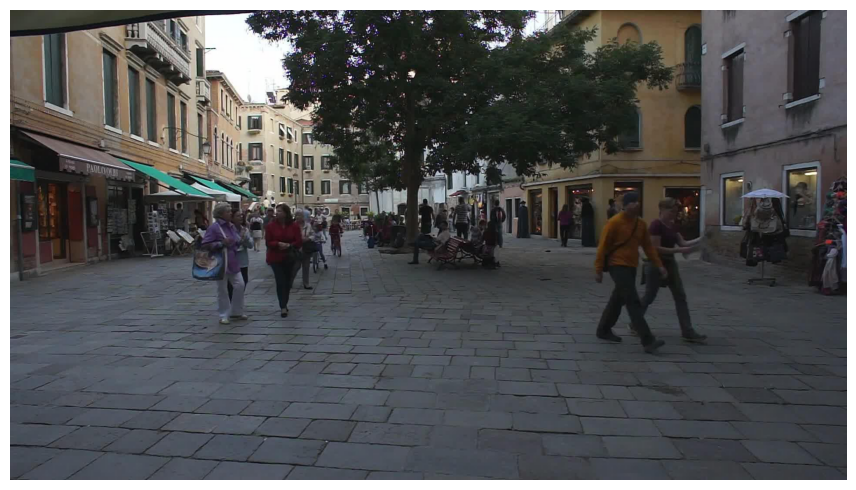

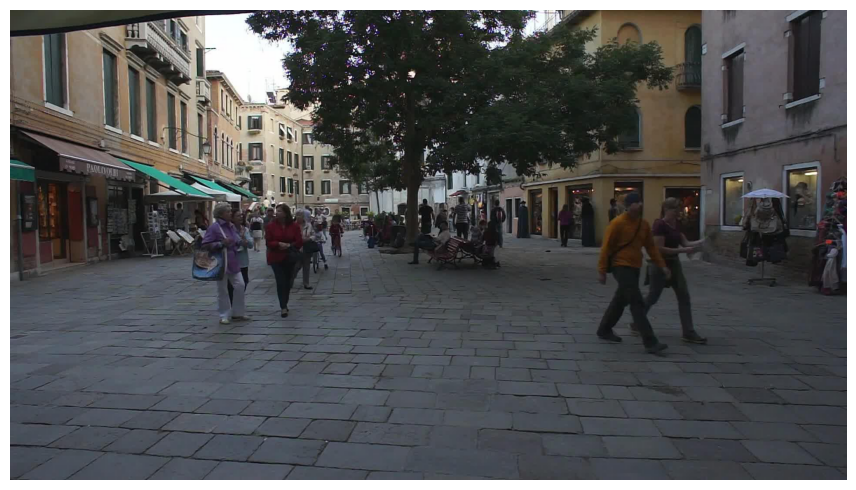

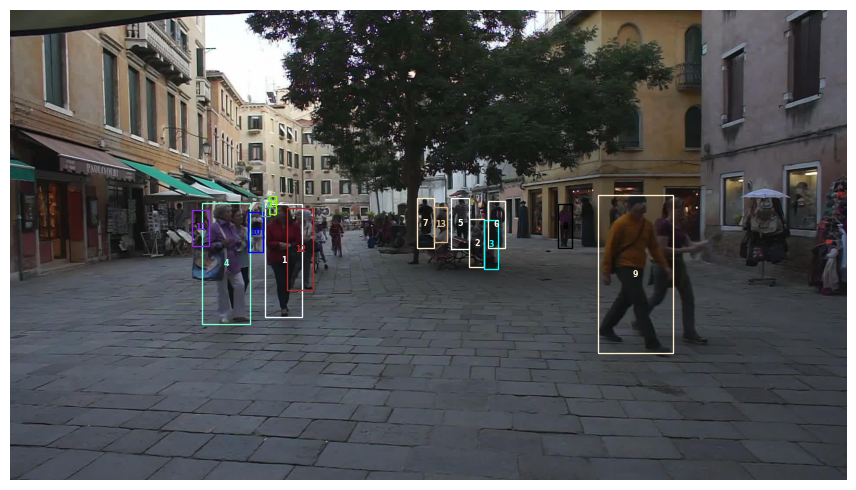

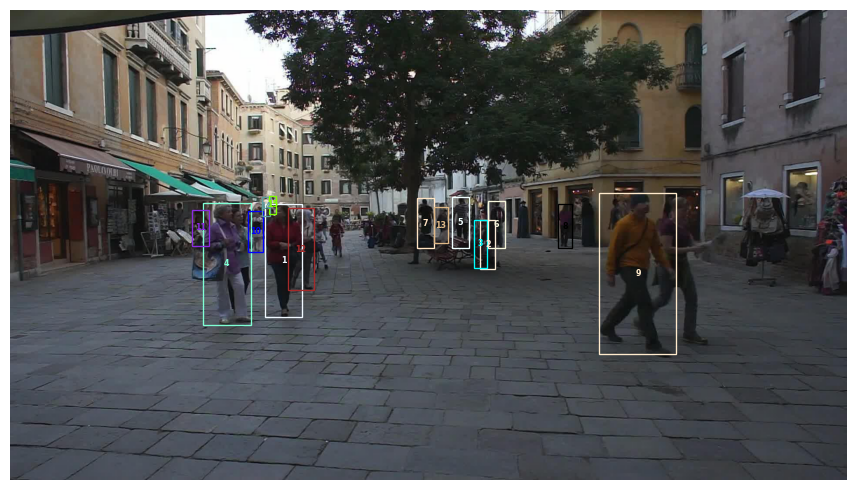

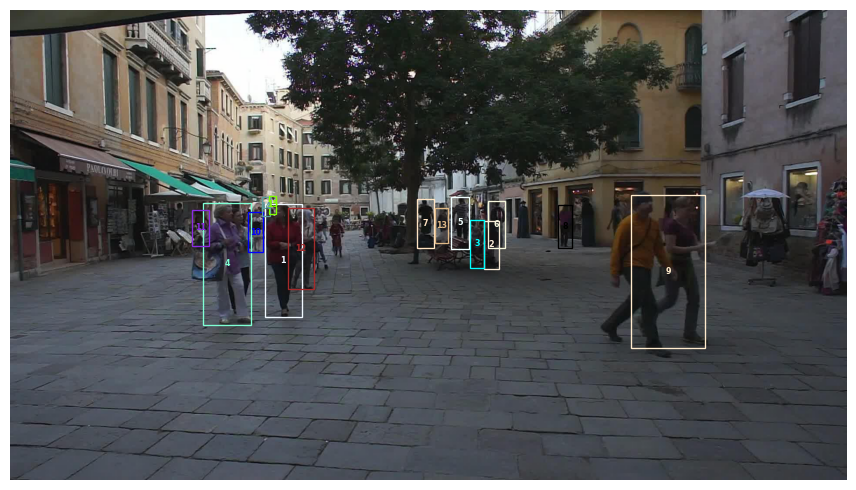

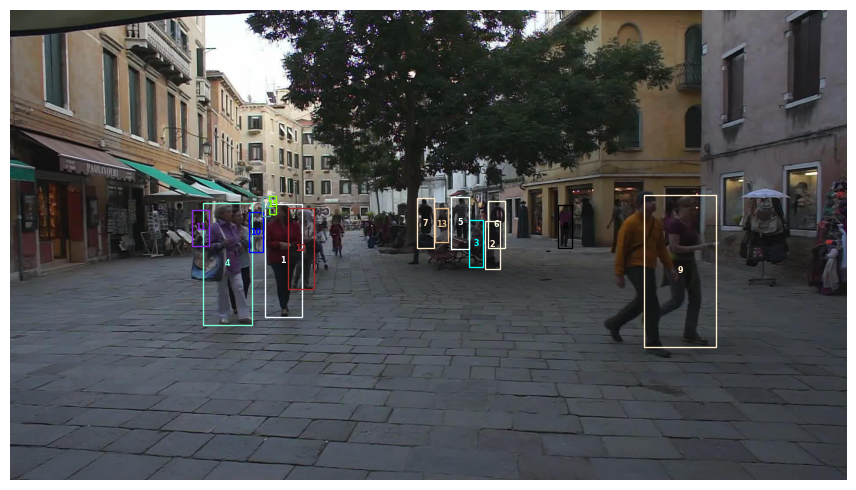

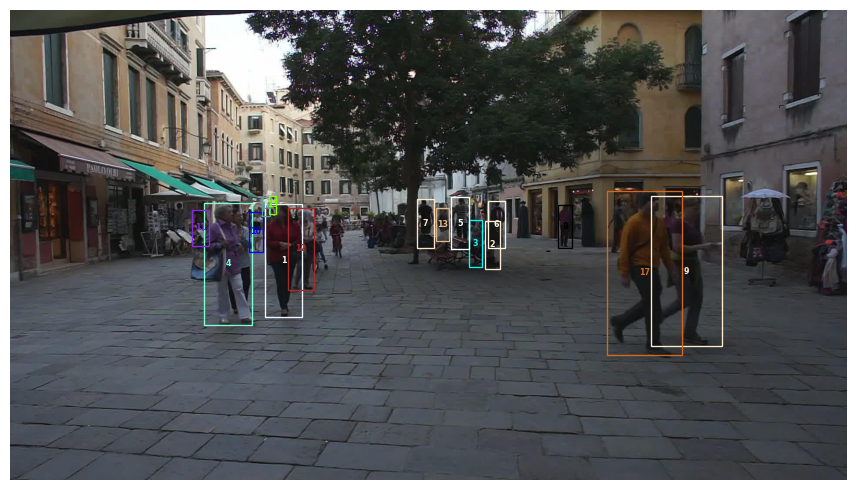

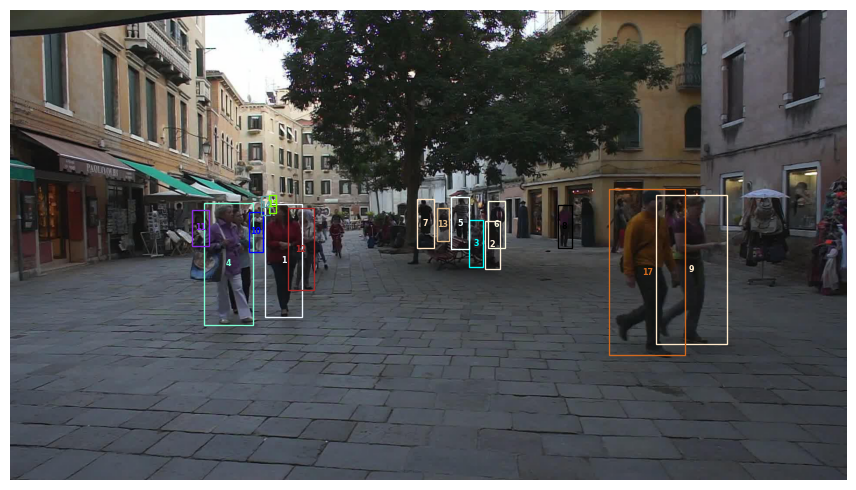

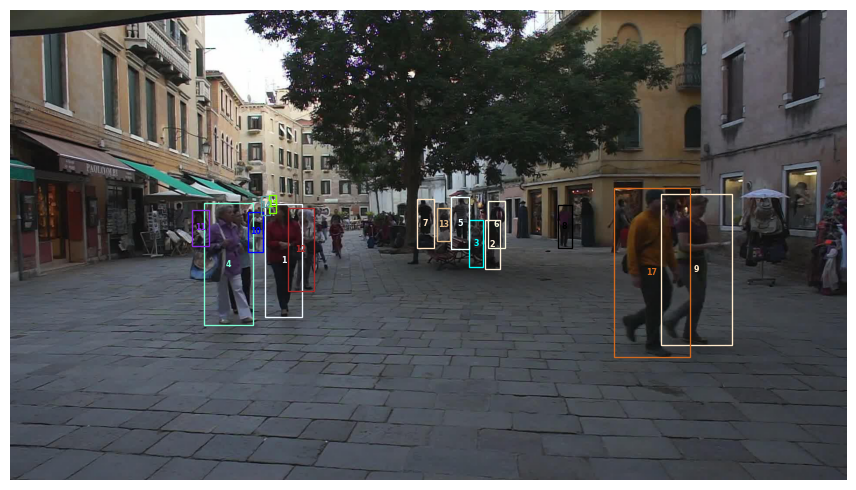

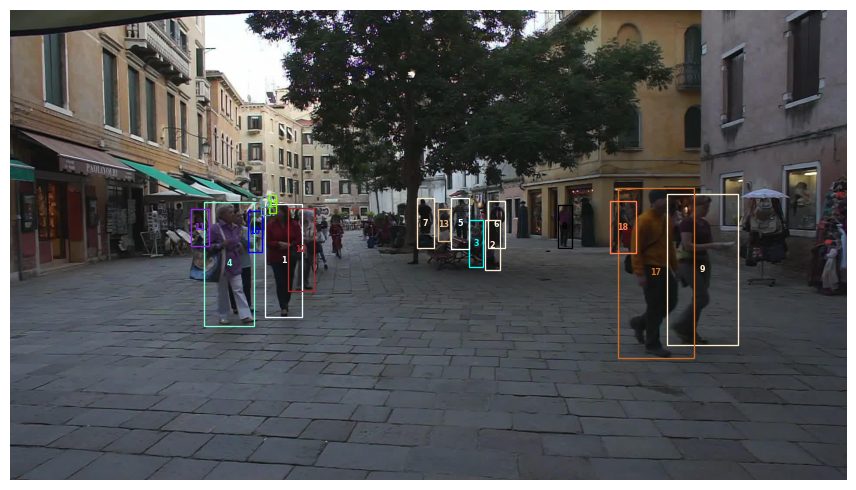

In [26]:
plot_sequence(results_seq['MOT16-02'],
              [s for s in sequences if str(s) == 'MOT16-02'][0],
              first_n_frames=10)

# Notes and next steps

*   Experiment and debug on a single train sequence. If something works on a single sequence evaluate all train sequences to check the generaliztion of your improvement.
*   Remember to split the training set into multiple sets with different sequences if you train something and want to avoid overfitting.
*   Sometimes the execution of a cell gets stuck. If this happends just abort the execution and restart the cell.
*   If the notebook warns you that currently no GPU hardware acceleration is available, try again later and focus on some debugging or experiments than can be done only with the CPU.
* Try to improve your results on your local train/validation splits before submitting to our test servers. The submission will be limited to avoid overfitting to the test sequences.


# Exercise submission

The `seq.write_results(results, os.path.join(output_dir))` statement saves predicted tracks into files. After executing this notebook the `output` directory in your Google Drive should contain multiple `MOT16-XY.txt` files.

For the final submission you have to process the test sequences and upload the zipped prediction files to our server. More information on this will follow.

We will make the test sequences and minimum `MOTA` for receiving the exam bonus available by the end of december.

In [ ]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/"

MOT16-02.txt  MOT16-05.txt  MOT16-10.txt  MOT16-13.txt
MOT16-04.txt  MOT16-09.txt  MOT16-11.txt
